In [1]:
import dataclasses
from collections.abc import Sequence
from typing import Any, Literal

import ipywidgets as widgets
import numpy as np
from emevo import birth_and_death as bd
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
from matplotlib.lines import Line2D
from matplotlib.text import Text
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from emevo.plotting import (
    vis_birth,
    vis_expected_n_children,
    vis_hazard,
    vis_lifetime,
    show_params_text,
)

%matplotlib ipympl

In [2]:
def make_slider(
    vmin: float,
    vmax: float,
    logscale: bool = True,
    n_steps: int = 400,
) -> widgets.FloatSlider | widgets.FloatLogSlider:
    if logscale:
        logmin = np.log10(vmin)
        logmax = np.log10(vmax)
        logstep = (logmax - logmin) / n_steps
        return widgets.FloatLogSlider(
            min=logmin,
            max=logmax,
            step=logstep,
            value=10 ** ((logmax + logmin) / 2.0),
            base=10,
            readout_format=".3e",
        )
    else:
        str_vmin = str(min(abs(vmin), abs(vmax)))
        dot = str_vmin.find(".")
        if dot != -1:
            format_n = len(str_vmin[dot + 1: ].rstrip("0"))
            readout_format=f".{format_n + 1}e"
        else:
            readout_format = ".2f"
        return widgets.FloatSlider(
            min=vmin,
            max=vmax,
            step=(vmax - vmin) / n_steps,
            value=(vmax + vmin) / 2,
            readout_format=readout_format,
        )

In [3]:
def savefig_widgets(fig: Figure) -> list:
    text = widgets.Text(
        value="figure.png",
        description="Filename:",
        disabled=False,
    )
    button = widgets.Button(description="Save File")
    output = widgets.Output()

    def on_button_clicked(b):
        filename = text.value
        if any([filename.endswith(ext) for ext in [".png", ".svg", ".pdf"]]):
            fig.savefig(filename)
        else:
            with output:
                print("Enter valid file name!")
    
    button.on_click(on_button_clicked)
    return [text, button, output]

In [5]:
def make_hazard_widget(
    age_max: int = 10000,
    energy_max: float = 16,
    n_discr: int = 101,
    hazard_cls: type[bd.HazardFunction] = bd.GompertzHazard,
    methods: Sequence[Literal["hazard", "cumulative hazard", "survival"]] = ("hazard",),
    fixed_params: dict[str, Any] | None = None,
    **kwargs,
) -> widgets.VBox:
    if fixed_params is None:
        fixed_params = {}
    n_methods = len(methods)
    fig = plt.figure(figsize=(6 * n_methods, 6))
    axes = []
    for i in range(n_methods):
        ax = fig.add_subplot(1, n_methods, i + 1, projection="3d")
        ax.set_title(f"{hazard_cls.__name__} {methods[i]} function")
        axes.append(ax)

    @dataclasses.dataclass
    class State:
        surfs: list[Poly3DCollection]
        text: Text | None = None

    state = State([None] * len(methods), None)

    def update_figure(**params):
        hazard_fn = hazard_cls(**fixed_params, **params)
        if state.text is None:
            initial = True
        else:
            initial = False
            state.text.remove()
        for i in range(len(methods)):
            if state.surfs[i] is not None:
                state.surfs[i].remove()
            state.surfs[i], text = vis_hazard(
                axes[i],
                hazard_fn=hazard_fn,
                age_max=age_max,
                energy_max=energy_max,
                n_discr=n_discr,
                method=methods[i],
                initial=initial,
                shown_params=params if i == 0 else None,
            )
            if i == 0:
                state.text = text
        fig.canvas.draw()
        fig.canvas.flush_events()

    sliders = {key: make_slider(*range_) for key, range_ in kwargs.items()}
    interactive = widgets.interactive(update_figure, **sliders)
    return widgets.VBox(savefig_widgets(fig) + [interactive])

In [6]:
def make_n_children_widget(
    energy_max: float = 16,
    n_discr: int = 101,
    birth_cls: type[bd.BirthFunction] = bd.EnergyLogisticBirth,
    hazard_cls: type[bd.HazardFunction] = bd.GompertzHazard,
    hazard_fixed_params: dict[str, Any] | None = None,
    birth_fixed_params: dict[str, Any] | None = None,
    **kwargs,
) -> widgets.VBox:
    fig = plt.figure(figsize=(6, 12))
    ax1 = fig.add_subplot(211)
    ax1.set_title(f"{hazard_cls.__name__} Expected Lifetime")
    ax2 = fig.add_subplot(212)
    ax2.set_title(f"{hazard_cls.__name__} Expected Num. of children")

    if hazard_fixed_params is None:
        hazard_fixed_params = {}
    if birth_fixed_params is None:
        birth_fixed_params = {}

    @dataclasses.dataclass
    class State:
        lines: list[Line2D | None] 
        texts: list[Text]

    state = State([None, None], [])

    def update_figure(**params):
        hazard_params, birth_params = {}, {}
        for key, value in params.items():
            if key.startswith("birth_"):
                birth_params[key[len("birth_") :]] = value
            else:
                hazard_params[key] = value

        hazard_fn = hazard_cls(**hazard_fixed_params, **hazard_params)
        birth_fn = birth_cls(**birth_fixed_params, **birth_params)
        if len(state.texts) == 0:
            initial = True
        else:
            initial = False
            for text in state.texts:
                text.remove()
            state.texts.clear()
            for line in state.lines:
                line.remove()

        state.lines[0] = vis_lifetime(
            ax1,
            hazard_fn=hazard_fn,
            energy_max=energy_max,
            n_discr=n_discr,
            initial=initial,
        )
        state.lines[1] = vis_expected_n_children(
            ax2,
            birth_fn=birth_fn,
            hazard_fn=hazard_fn,
            energy_max=energy_max,
            n_discr=n_discr,
            initial=initial,
        )
        state.texts = show_params_text(ax1, params, columns=2)

        fig.canvas.draw()
        fig.canvas.flush_events()

    sliders = {key: make_slider(*range_) for key, range_ in kwargs.items()}
    interactive = widgets.interactive(update_figure, **sliders)
    return widgets.VBox(savefig_widgets(fig) + [interactive])

In [7]:
def make_birth_widget(
    age_max: int = 10000,
    energy_max: float = 16,
    n_discr: int = 101,
    birth_cls: type[bd.BirthFunction] = bd.EnergyLogisticBirth,
    **kwargs,
) -> widgets.VBox:
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.set_title(f"{birth_cls.__name__} birth function")

    @dataclasses.dataclass
    class State:
        surf: Poly3DCollection | None = None
        text: Text | None = None

    state = State()

    def update_figure(**params):
        birth_fn = birth_cls(**params)
        if state.text is not None and state.surf is not None:
            initial = False
            state.text.remove()
            state.surf.remove()
        else:
            initial = True

        state.surf, state.text = vis_birth(
            ax,
            birth_fn=birth_fn,
            age_max=age_max,
            energy_max=energy_max,
            n_discr=n_discr,
            initial=initial,
            shown_params=params,
        )

        fig.canvas.draw()
        fig.canvas.flush_events()

    sliders = {key: make_slider(*range_) for key, range_ in kwargs.items()}
    interactive = widgets.interactive(update_figure, **sliders)
    return widgets.VBox(savefig_widgets(fig) + [interactive])

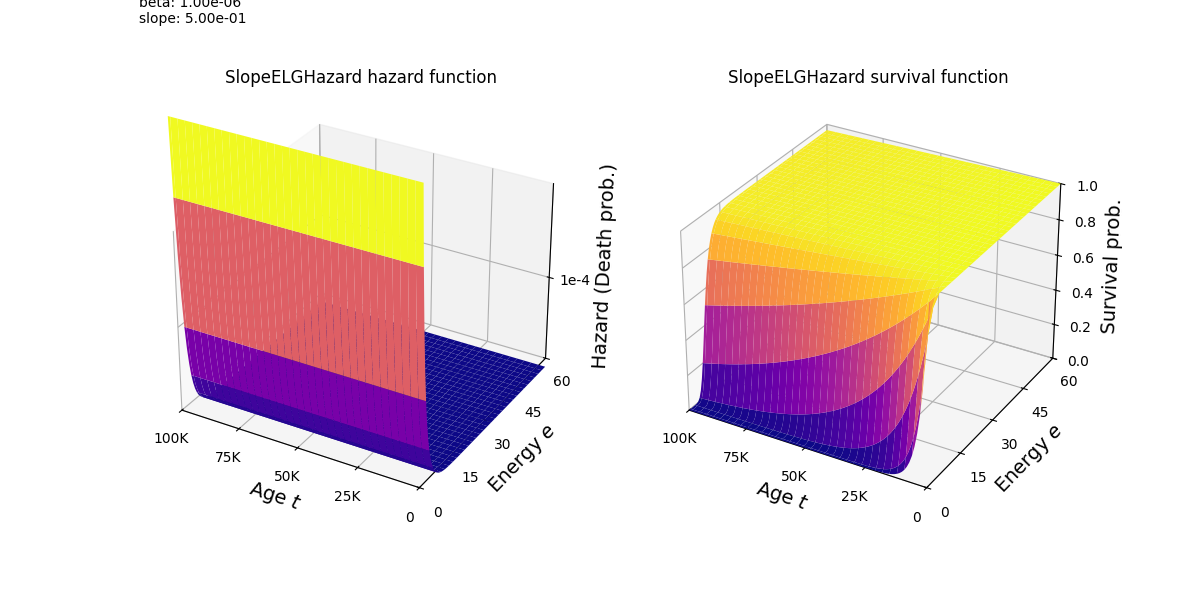

In [8]:
make_hazard_widget(
    scale=(1e-3, 1.0),
    alpha_age=(1e-8, 1e-5),
    alpha=(0.001, 0.1),
    beta=(1e-7, 1e-5),
    slope=(0, 1.0, False),
    methods=["hazard", "survival"],
    age_max=100000,
    energy_max=60,
    hazard_cls=bd.SlopeELGHazard,
)

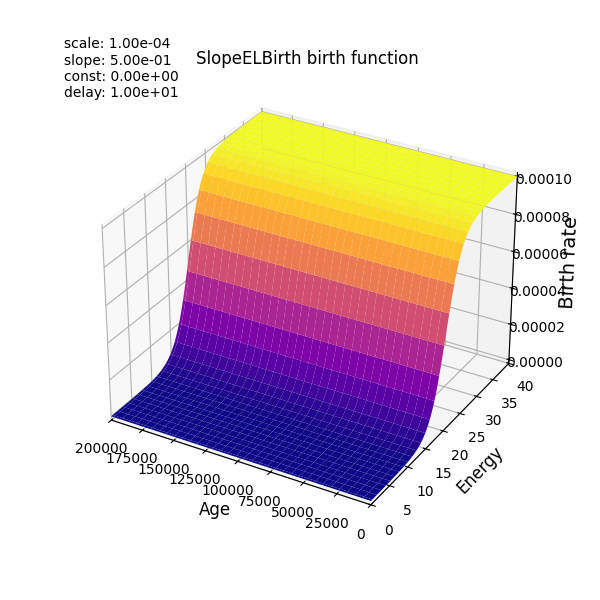

In [9]:
make_birth_widget(
    scale=(1e-5, 1e-3),
    slope=(0, 1.0, False),
    const=(-0.001, 0.001, False),
    delay=(0, 20, False),
    age_max=200000,
    energy_max=40,
    birth_cls=bd.SlopeELBirth,
)

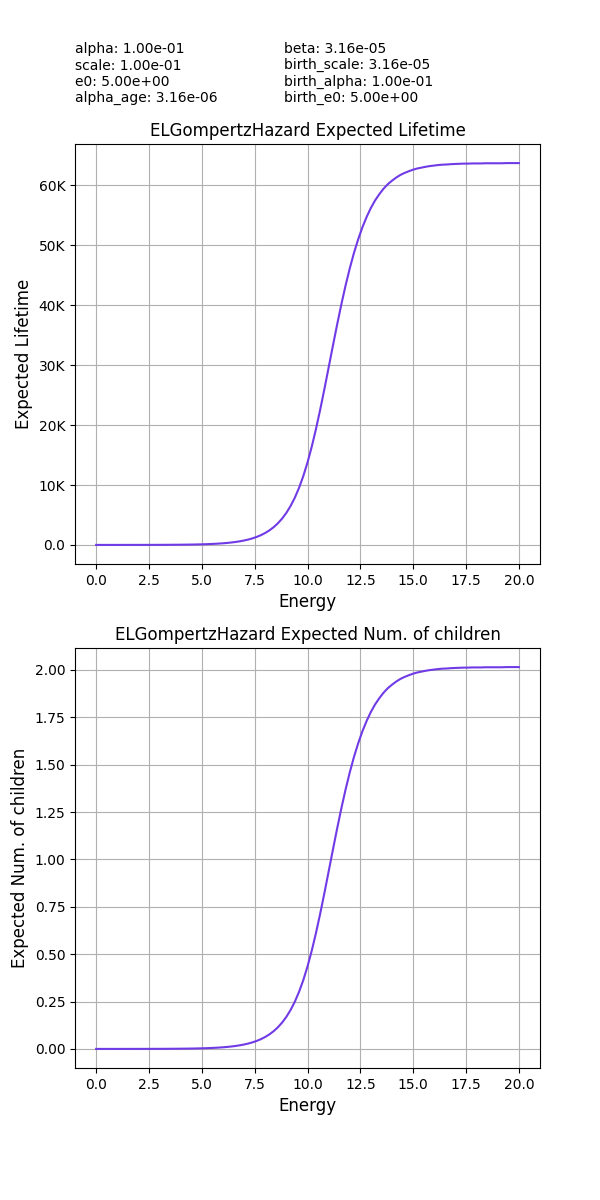

In [10]:
make_n_children_widget(
    alpha=(1e-2, 1.0),
    scale=(1e-2, 1.0),
    e0=(0, 10, False),
    alpha_age=(1e-7, 1e-4),
    beta=(1e-6, 1e-3),
    energy_max=20,
    hazard_cls=bd.ELGompertzHazard,
    birth_scale=(1e-6, 1e-3),
    birth_alpha=(1e-2, 1.0),
    birth_e0=(0, 10, False),
)